## 22-01-2018 -- In this notebook, I:
1 - Download and parse the Most Important Issue (MII) tables from the Ipsos Mori Issues Index:
https://www.ipsos.com/ipsos-mori/en-uk/issues-index-archive

This website contains tables with monthly answers to the following questions:
- What would you say is the most important issue facing Britain today?
- What do you see as other important issues facing Britain today

First, I download all monthly tables from 1974 to 2017, turn them into a single csv file.

2 - Analyse the MII, looking at:
- The entropy of the MII distribution over time
- The month-to-month relative entropy of the MII distribution, measuring how surprising a month was, given the previous month
- The year-to-year relative entropy of the MII distribution (same idea).

Given that the MII distributions often contain topics that were absent on that given month or year, the true relative entropy in that case is not defined (https://mathoverflow.net/questions/72668/how-to-compute-kl-divergence-when-pmf-contains-0s). I then use two diferent heuristics, which are filling all zeros with a small value (say, 0.1 or 0.01) and filling only the zeros which are being compared to non-zero entries in the other month or year. I compare the results of these two heuristics to the hamming distance. The results are shown below.

I also discuss the problem of overlapping issue, such as "Race Relations/Immigration/Immigrants" and "Immigrants". The latter was added in 2015, leading to an apparent change in MII, where it is actually just a change in categorisation. The next steps should include merging of some of these issues.

In [2]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})

from scipy.stats import entropy
entropy_fix = np.log2(np.e)

## 1 - Download and parse the Most Important Issue tables:

In [230]:
class HTMLTableParser:

    def parse_url(self, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        return [(table['id'],self.parse_html_table(table)) for table in soup.find_all('table')]  

    def parse_html_table(self, table):
        print("Parsing table "+table['id'])
        
        n_columns = 0
        n_rows=0
        column_names = []

        # Find number of rows and columns
        # we also find the column titles if we can
        for row in table.find_all('tr'):

            # Determine the number of rows in the table
            td_tags = row.find_all('td')
            if len(td_tags) > 0:
                n_rows+=1
                if n_columns == 0:
                    # Set the number of columns for our table
                    n_columns = len(td_tags)

            # Handle column names if we find them
            th_tags = row.find_all('th') 
            if len(th_tags) > 0 and len(column_names) == 0:
                for th in th_tags:
                    column_names.append(th.get_text())

        # Safeguard on Column Titles
        if len(column_names) > 0 and len(column_names) != n_columns:
            #print(len(column_names),n_columns)
            #raise Exception("Column titles do not match the number of columns")
            print("Column titles do not match the number of columns, so I'm using the lowest")
            n_columns = min(n_columns,len(column_names))


        columns = column_names if len(column_names) > 0 else range(0,n_columns)
        df = pd.DataFrame(columns = columns,
                          index= range(0,n_rows))
        row_marker = 0
        for row in table.find_all('tr'):
            column_marker = 0
            columns = row.find_all('td')
            for column in columns[:n_columns]:
                df.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1

        # Convert to float if possible
        for col in df:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass

        return df

In [231]:
hp = HTMLTableParser()

url_list = [ 'https://www.ipsos.com/ipsos-mori/en-uk/issues-index-trends-1974-1987',
             'https://www.ipsos.com/ipsos-mori/en-uk/issues-index-trends-1988-1997',
             'https://www.ipsos.com/ipsos-mori/en-uk/issues-index-1997-2006',
             'https://www.ipsos.com/ipsos-mori/en-uk/issues-index-2007-onwards' ]

table_list = []
for url in url_list:
    table_list.extend( hp.parse_url(url) ) 
table_list = np.array(table_list)

Parsing table 1974
Parsing table 1980
Parsing table 1984
Parsing table 1985
Parsing table 1986
Parsing table 1987
Parsing table 1988
Parsing table 1989
Parsing table 1990
Parsing table 1991
Parsing table 1992
Parsing table 1993
Parsing table 1994
Parsing table 1995
Parsing table 1996
Parsing table 1997
Parsing table 1997
Parsing table 1998
Parsing table 1999
Parsing table 2000
Parsing table 2001
Parsing table 2002
Parsing table 2003
Parsing table 2004
Parsing table 2005
Parsing table 2006
Parsing table 2007
Parsing table 2008
Parsing table 2009
Parsing table 2009
Parsing table 2011
Parsing table 2012
Column titles do not match the number of columns, so I'm using the lowest
Parsing table 2013
Column titles do not match the number of columns, so I'm using the lowest
Parsing table 2014
Column titles do not match the number of columns, so I'm using the lowest
Parsing table 2015
Column titles do not match the number of columns, so I'm using the lowest
Parsing table 2016
Column titles do not

In [232]:
for table_pair in table_list:
    table = table_pair[1]
    table['year'] = [ table_pair[0] ]*(len(table))
    table_pair[1] = table.rename(index=str, columns={ table.keys()[0]:'month' })
    
table = table_list[0][1] # Grabbing the table from the tuple
table.head()

,month,AID,BF,BSE,Coa,Com,Cou,Cri,Def,Dru,...,SA,SWA,Tax,TU,Tra,Tsu,Une,Oth,DK,year
0,Sep-74,,,,,19,,8,,,...,,,,22.0,,,9.0,,,1974
1,Oct-74,,,,,10,,9,,,...,,,,18.0,,,8.0,,,1974
2,Nov-77,,,,,,,,,,...,,,,30.0,,,50.0,,,1974
3,Aug-78,,,,,9,,23,,,...,,,,25.0,,,55.0,,,1974
4,Feb-79,,,,,9,,14,,,...,,,,73.0,,,31.0,,,1974


In [239]:
all_table_keys = reduce(set.union, [ set(table_pair[1].keys()[1:]) for table_pair in table_list ])
table_keys = sorted(all_table_keys)

print(table_keys)

['AG', 'AID', 'AW', 'BF', 'BSE', 'Coa', 'Com', 'Cou', 'Cri', 'DK', 'Def', 'Dru', 'Eco', 'Edu', 'Foo', 'GM', 'Ger', 'Hea', 'Hou', 'Imm', 'Inf', 'Inn', 'LG', 'Lac', 'Low', 'Mor', 'NHS', 'NI', 'NP', 'Nat', 'Nuc', 'Oth', 'Pen', 'Pet', 'Pol', 'Pou', 'Pov', 'Pri', 'Pub', 'Rac', 'SA', 'SWA', 'TU', 'Tax', 'Tra', 'Tsu', 'Une', 'year']


In [241]:
for table_pair in table_list:
    table = table_pair[1]
    for key in table_keys:
        if key not in table:
            table[key] = [ '0' ]*(len(table))
            table_pair[1] = table
            #print("filling "+table_pair[0]+"["+key+"] with *")

In [574]:
table = pd.concat( table_list[:,1], ignore_index=True)
table = table.drop(range(405,410))

idx_2010 = table[ (table.date>='2010-01-01') & (table.date<'2011-01-01') ].index

for idx in idx_2010:
    table['year'][idx] = 2010

table.to_csv('MORI_table.csv')
table.head()

,AG,AID,AW,BF,BSE,Coa,Com,Cou,Cri,DK,...,Rac,SA,SWA,TU,Tax,Tra,Tsu,Une,month,year
0,0,,0,,,,19,,8,,...,7,,,22,,,,9,Sep-74,1974
1,0,,0,,,,10,,9,,...,5,,,18,,,,8,Oct-74,1974
2,0,,0,,,,,,,,...,16,,,30,,,,50,Nov-77,1974
3,0,,0,,,,9,,23,,...,27,,,25,,,,55,Aug-78,1974
4,0,,0,,,,9,,14,,...,10,,,73,,,,31,Feb-79,1974


## 2 - Process the MII tables

In [ ]:
issues_table = pd.read_csv('MORI_table.csv', index_col=0)

issues_table = issues_table.replace('\xa0*\xa0', '*').replace('*\xa0', '*').replace('\xa0*', '*')
issues_table = issues_table.replace('*', 0.25).replace('\xa0', -1).replace('-', -1)

for key in issues_table:
    if key != 'month':
        issues_table[key] = [ float(i) for i in issues_table[key].values ]

issues_table = issues_table.drop(range(29))
issues_table = issues_table.drop([174])
issues_table.head()

In [27]:
dates = [ datetime.strptime(m.replace('Sept','Sep').replace('General Election 1 April 1997','Apr-97'), '%b-%y') for m in issues_table.month.values ]
issues_table['date'] = dates

issues_table.head()

,AG,AID,AW,BF,BSE,Coa,Com,Cou,Cri,DK,...,SA,SWA,TU,Tax,Tra,Tsu,Une,month,year,date
29,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,10.0,-1.0,...,-1.0,-1.0,26.0,-1.0,-1.0,-1.0,82.0,Jan-85,1985.0,1985-01-01
30,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,8.0,-1.0,...,-1.0,-1.0,26.0,-1.0,-1.0,-1.0,79.0,Feb-85,1985.0,1985-02-01
31,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,13.0,-1.0,...,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,85.0,Mar-85,1985.0,1985-03-01
32,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,12.0,-1.0,...,-1.0,-1.0,9.0,-1.0,-1.0,-1.0,85.0,Apr-85,1985.0,1985-04-01
33,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,15.0,-1.0,...,-1.0,-1.0,5.0,-1.0,-1.0,-1.0,85.0,May-85,1985.0,1985-05-01


In [15]:
issues_table = pd.read_csv('MORI-month_table.csv', index_col=0)

In [45]:
table = issues_table

table.drop(235)

all_entropies = []

for index, row in table.iterrows():
    #print( sum([ row[key]>0 for key in row.keys()[:-3] ])  )
    topic_array = np.array([ row[key]  for key in row.keys()[:-3] if row[key]>0 ])
    all_entropies += [ entropy(topic_array)*entropy_fix ]
all_entropies = np.array(all_entropies)

In [46]:
n_issues = []

for index, row in table.iterrows():
    n_issues += [ sum([ row[key]>0 for key in row.keys()[:-3] ]) ]
n_issues = np.array(n_issues)

In [1]:
fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

ys = [ [ s                if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ n                if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ s/(n*np.log2(n)) if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ 2**s             if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ]
     ]


xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ylabels = ['entropy($H$)', 'number of issues', 'entropy/maxent', r'effective number of issues ($2^H$)']
for ax,y,ylabel in zip(axs,ys,ylabels):
    ax.plot(issues_table.date, y, '.-')
    ax.set_ylabel(ylabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

The entropy of the MII distribution rises over time, but so does the number of issues included in the MII.

The effective number of issues, given by 2^(entropy), also increases. This says that there are more topics in the public mind, but it doesn't say whether they are changing.

This is also seen in the total number of answers, which also increases, but which does not affect entropy measures:

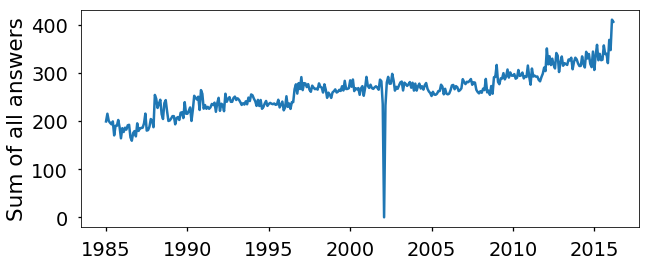

In [154]:
sum_answers = [ sum(row[key] for key in month_table.keys()[:-3]) for index, row in month_table.iterrows() ]

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ax.plot(table.index[1:], hammings[ep], '.-', c='g')

fig, ax = plt.subplots(1, figsize=(10,4))
ax.plot(sum_answers)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel('Sum of all answers')
plt.show()

In [155]:
table = issues_table.replace(-1, 0)
month_table = table
month_table.to_csv('MORI-month_table.csv')

## 3 - Make novelty plots

In [5]:
month_table = pd.read_csv('MORI-month_table.csv', index_col=0)

month_table.head()

,AG,AID,AW,BF,BSE,Coa,Com,Cou,Cri,DK,...,SA,SWA,TU,Tax,Tra,Tsu,Une,month,year,date
29,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,10.0,0.0,...,0.0,0.0,26.0,0.0,0.0,0.0,82.0,Jan-85,1985.0,1985-01-01
30,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8.0,0.0,...,0.0,0.0,26.0,0.0,0.0,0.0,79.0,Feb-85,1985.0,1985-02-01
31,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,13.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,85.0,Mar-85,1985.0,1985-03-01
32,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,12.0,0.0,...,0.0,0.0,9.0,0.0,0.0,0.0,85.0,Apr-85,1985.0,1985-04-01
33,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,15.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,85.0,May-85,1985.0,1985-05-01


In [65]:
from scipy.spatial.distance import hamming

def novelty(p,q,metric='KL',ep=0.01, faz=True):
    
    if metric=='KL':
        return rel_entr(p,q,ep=ep,fill_all_zeros=faz)
    elif metric=='hamming':
        return hamming(p>0,q>0)
    else:
        return 0

    
def rel_entr(p, q, ep=0.01, fill_all_zeros=True):
    if fill_all_zeros is True:
        P = p.copy()
        Q = q.copy()   
        P[P==0] = ep
        Q[Q==0] = ep
        return entropy(list(P), list(Q))*entropy_fix
    
    else:
        P = p.copy()
        Q = q.copy()
        for i in zip(range(len(P))):
            if P[i] == 0:
                if Q[i] != 0:
                    P[i] = ep
                else: # Q[i] == 0
                    continue
            else:# P[i] != 0
                if P[i] != 0:
                    Q[i] = ep
                else: # P[i] == 0
                    continue
        return entropy(list(P), list(Q))*entropy_fix
    """
    P = p.copy()
    Q = q.copy()
    if sum(p)>0:
        P = P/sum(P)
    if sum(q)>0:
        Q = Q/sum(Q)
    s = 0
    for i,j in zip(P,Q):
        if i!=0 and j!=0:
            s += i*np.log2(i/j)
    return s
    """

In [6]:
table = month_table
issues_tplus1 = table[table.index>table.index[0]]

eps = [0.001, 0.01, 0.1, 0.2]
KLs_faz_True = {}
KLs_faz_False = {}
hammings = {}

for ep in eps:
    relative_entropies_True = []
    relative_entropies_False = []
    relative_entropies_hamm = []
    
    row = table.iloc[0]
    previous_topic_array = np.array(row.values[:-3])
   
    for index, row in issues_tplus1.iterrows():
        topic_array = np.array(row.values[:-3])
        relative_entropies_True  += [ novelty(topic_array, previous_topic_array, metric='KL', ep=ep, faz=True) ]
        relative_entropies_False += [ novelty(topic_array, previous_topic_array, metric='KL', ep=ep, faz=False) ]
        relative_entropies_hamm  += [ novelty(topic_array, previous_topic_array, metric='hamming') ]
        previous_topic_array = topic_array

    KLs_faz_True[ep]  = relative_entropies_True
    KLs_faz_False[ep] = relative_entropies_False
    hammings[ep]      = relative_entropies_hamm    

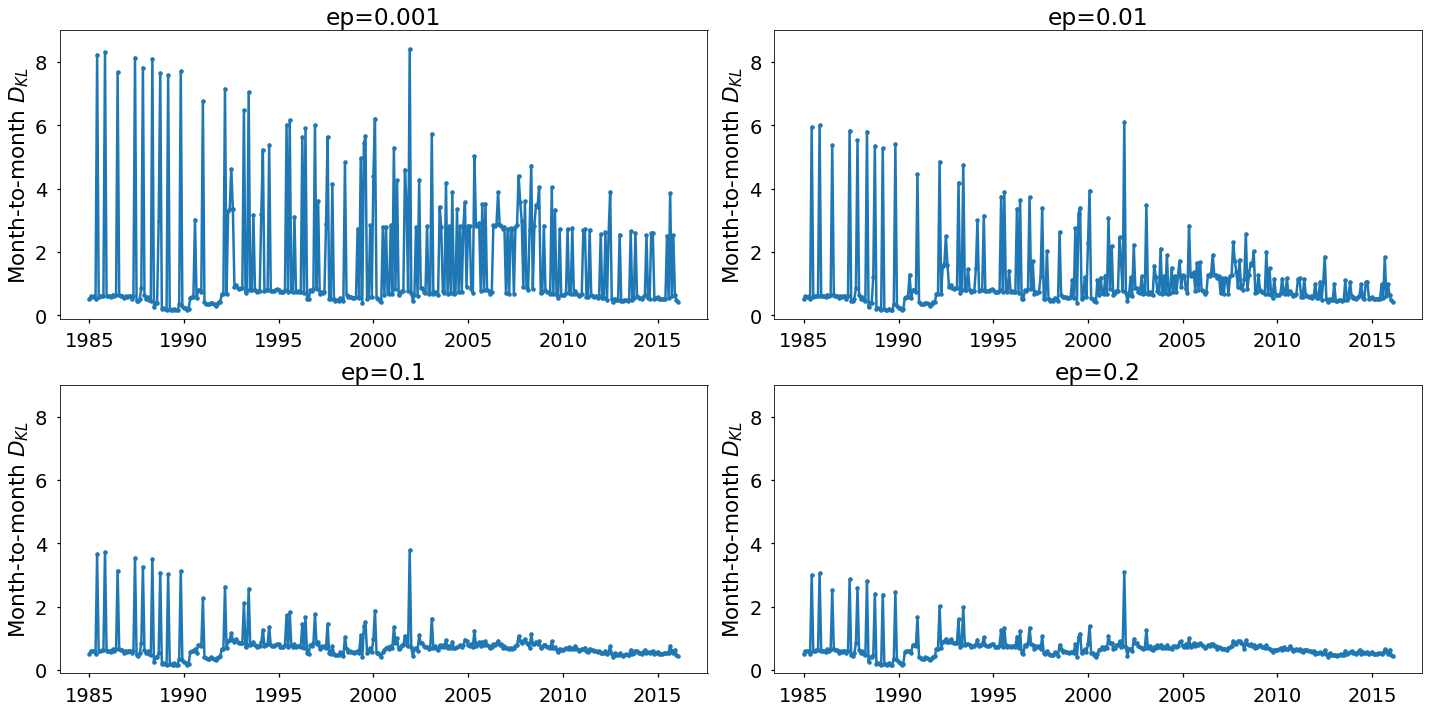

In [23]:
# Fill all zeros = False:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

for ep,ax in zip(eps,axs):
    ax.plot(month_table.date[1:], KLs_faz_False[ep], '.-')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Month-to-month $D_{KL}$')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(-0.1,9)
    
plt.tight_layout()
plt.show()

When filling only the zeros which are being compared to non-zero entries in the other month or year, the addition of new MIIs is a great surprise, reflecting in the high peaks in the earlier decades. Since those zeros are replaced by ep, lower values of ep such as ep=0.001 result in a higher surprise.

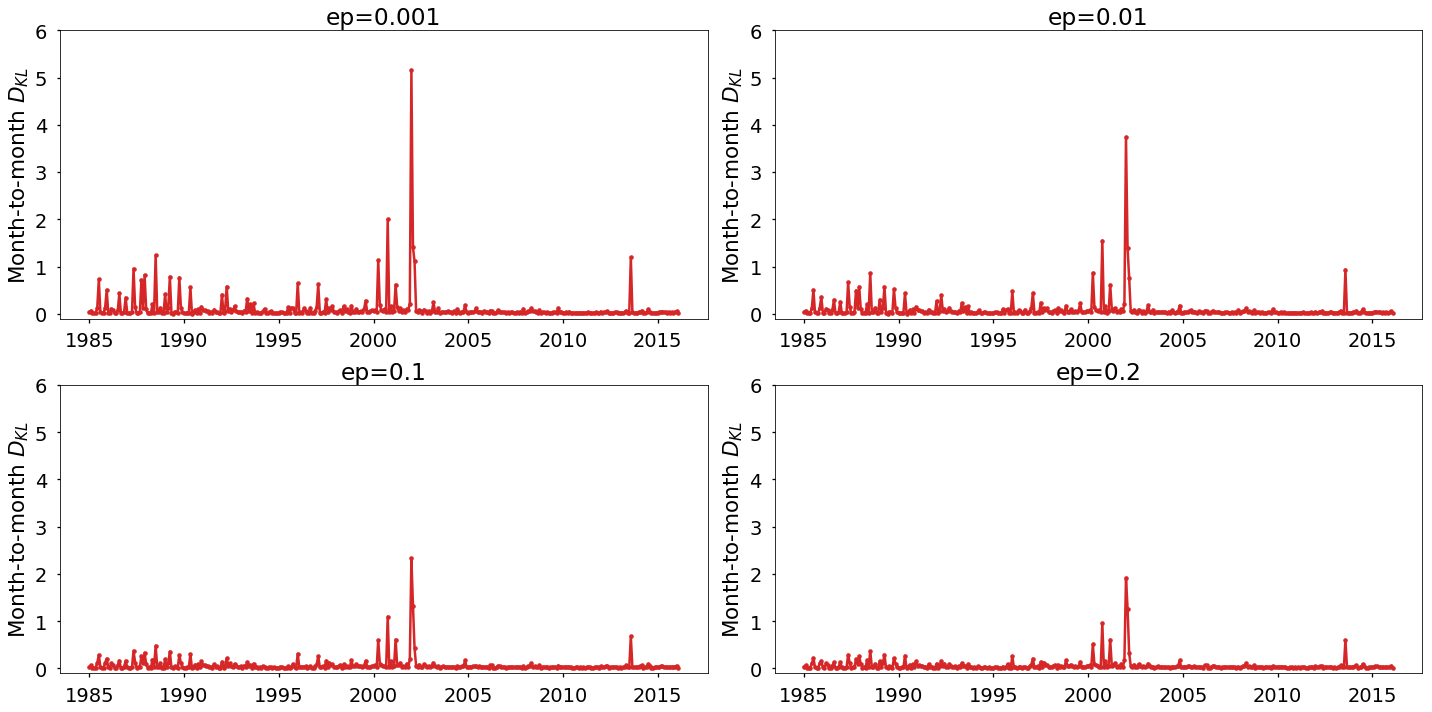

In [24]:
# Fill all zeros = True:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

for ep,ax in zip(eps,axs):
    ax.plot(month_table.date[1:], KLs_faz_True[ep], '.-', c='#d62728')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Month-to-month $D_{KL}$')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(-0.1,6)
    
plt.tight_layout()
plt.show()

When replacing all zeros with ep, the addition of new MIIs is still surprising, but less than what was shown above in blue. There are peaks in the earlier decades, but they are not as pronounced. Apart from that, the artificial parameter ep also does not make much difference here.

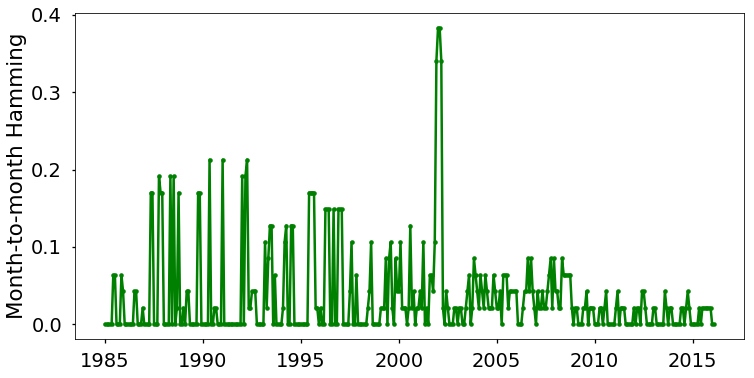

In [26]:
# Hamming distance
fig, ax = plt.subplots(1, figsize=(12,6))

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ax.plot(month_table.date[1:], hammings[ep], '.-', c='g')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-month Hamming')
plt.show()

The month-to-month Hamming distance, which is not affected by MIIs of zero importance, shows the addition/removal of MIIs.

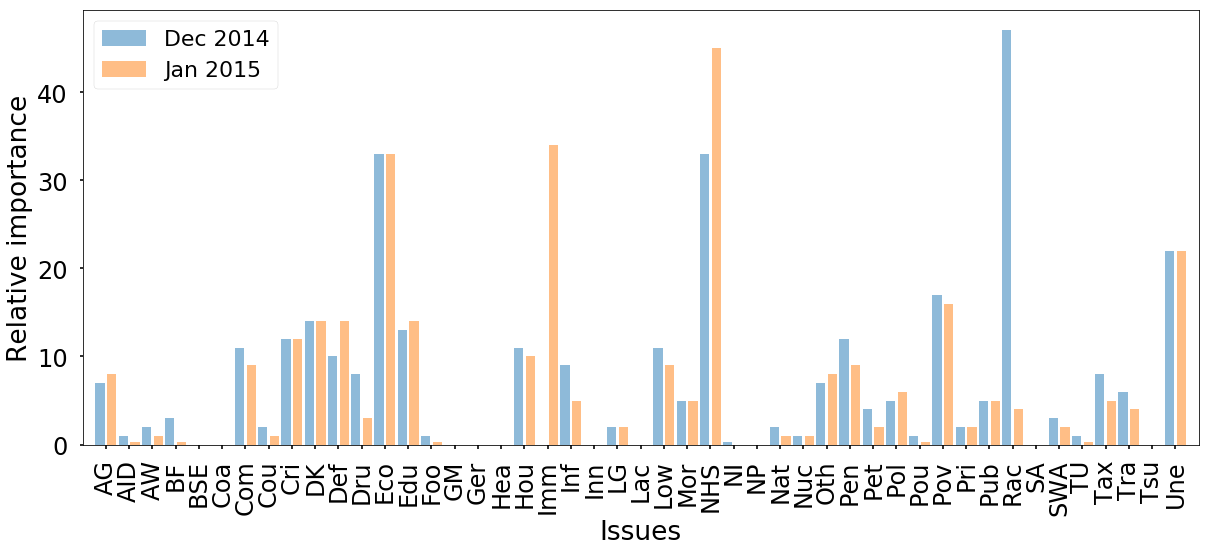

In [12]:
table = issues_table
keys = table.keys()[:-3]

v2014_12 = table[table.date=='2014-12-01'].values[0][:-3]
v2015_01 = table[table.date=='2015-01-01'].values[0][:-3]

v2014_12[v2014_12==0] = 0.01
v2014_12 = list(v2014_12)
v2015_01[v2015_01==0] = 0.01
v2015_01 = list(v2015_01)


fig, ax = plt.subplots(1, figsize=(20,8))

x = np.arange(len(keys))
ax.bar(2*x-1,  v2014_12, alpha=0.5, label='Dec 2014')
ax.bar(2*x,    v2015_01, alpha=0.5, label='Jan 2015')

ax.set_xticks(2*x-0.5)
ax.set_xticklabels(keys, rotation=90)
ax.set_xlim(-2.5,2*len(x)-0.5)
ax.set_xlabel('Issues')
ax.set_ylabel('Relative importance')

plt.legend(fontsize=22)
plt.savefig('Dec2014-Jan2015.png',dpi=300)
plt.show()

Note that the issue "Rac", which stands for "Race Relations/Immigration/Immigrants", overlaps with "Imm", standing for "Immigrants", which was introduced in January 2015. This explains the sudden change in MII observed in this month -- not really a change of MII, but a change in categorisation. In the next steps, it might be better to merge topics like these.

In [ ]:
month_table = pd.read_csv('MORI-month_table.csv', index_col=0)

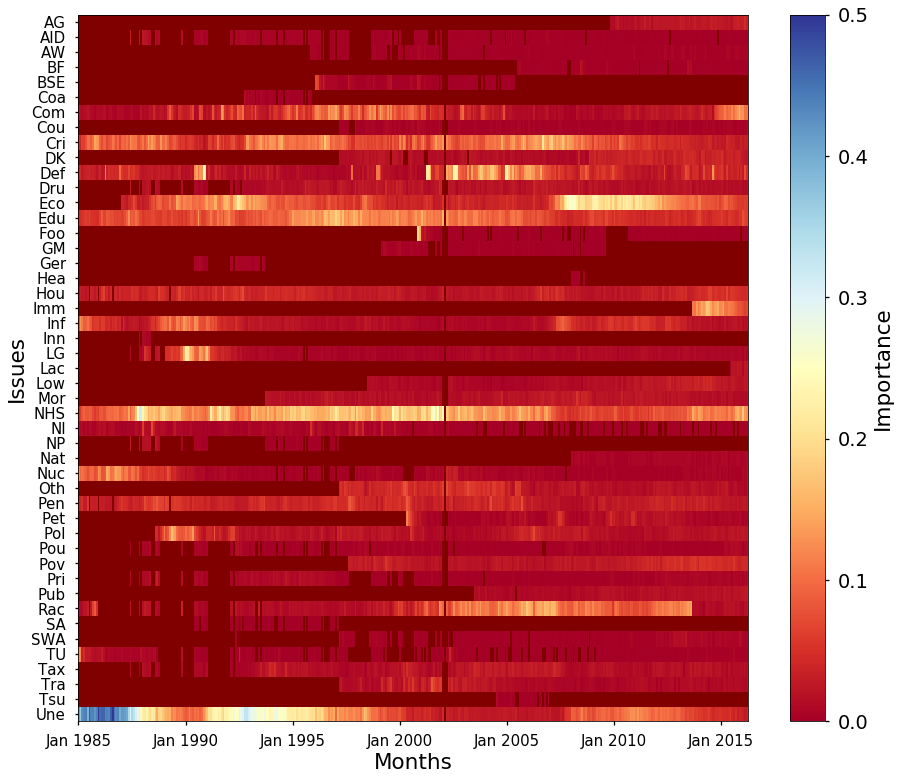

In [14]:
M = month_table.as_matrix()[:,:-3]
normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

fig, ax = plt.subplots(1, figsize=(15,13))

Mshow = np.flipud(normM.T)
Mshow[Mshow==0.0] = -1

pc = plt.pcolor(Mshow, cmap='RdYlBu')

#pc.cmap.set_under('rosybrown')
pc.cmap.set_under('maroon')
pc.set_clim(0,0.5)

c = plt.colorbar()
c.set_label('Importance')

keys = month_table.keys()[:-2]
yticks = np.arange(len(keys)-1)+0.5
yticklabels = list(reversed(keys.values[:-1]))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=15)
ax.set_ylabel('Issues')

xticks = np.arange(0,35*12,5*12)
xticklabels = [ 'Jan '+str(i) for i in np.arange(1985,2020,5) ]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=15)
ax.set_xlabel('Months')

plt.savefig('MII-per-month.png', dpi=200)
plt.show()

This heatmap shows the importance of every issue over time. Rows are normalised.

Note how some issues such as the Tsunami in South East Asia, and the new runway at Heathrow are very temporary, while others (NHS..) seem to always be a MII. The list of all MIIs is presented in the end of this notebook. 

In particular, this heatmap shows how "Imm" standing for "Immigrants", was introduced in January 2015, leading to the sudden increase in this MII, and decrease in "Rac", which stands for "Race Relations/Immigration/Immigrants".

## 4 - What if we aggregate it by years?

In [16]:
years_range = [ int(i) for i in set(issues_table.year) ]
keys = issues_table.keys()[:-3]

issues_table = issues_table.replace(-1, 0)

stats_years = []
for year in years_range:
    stats_years += [ tuple( [ issues_table[ issues_table.year==year ][key].sum() for key in keys ] + [year] ) ]

cols = list(keys)+['year']
years_table = pd.DataFrame( stats_years, columns=cols)
years_table.head()

,AG,AID,AW,BF,BSE,Coa,Com,Cou,Cri,DK,...,Pub,Rac,SA,SWA,TU,Tax,Tra,Tsu,Une,year
0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,205.0,0.0,...,0.0,63.0,0.0,0.0,99.00,0.0,0.0,0.0,989.0,1985
1,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,183.0,0.0,...,0.0,0.0,0.0,0.0,21.00,0.0,0.0,0.0,962.0,1986
2,0.0,6.0,0.0,0.0,0.0,0.0,14.0,0.0,190.0,0.0,...,0.0,4.0,0.0,0.0,12.00,2.0,0.0,0.0,674.0,1987
3,0.0,35.0,0.0,0.0,0.0,0.0,47.0,0.0,282.0,0.0,...,0.0,37.0,0.0,0.0,18.25,21.0,0.0,0.0,564.0,1988
4,0.0,0.0,0.0,0.0,0.0,0.0,88.0,0.0,212.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,346.0,1989


In [17]:
table = years_table

all_entropies = []

for index, row in table.iterrows():
    topic_array = np.array([ row[key]  for key in row.keys()[:-1] if row[key]>0 ])
    all_entropies += [ entropy(topic_array)*entropy_fix ]
all_entropies = np.array(all_entropies)

In [18]:
n_issues = []

for index, row in table.iterrows():
    n_issues += [ sum([ row[key]>0 for key in row.keys()[:-1] ]) ]
n_issues = np.array(n_issues)

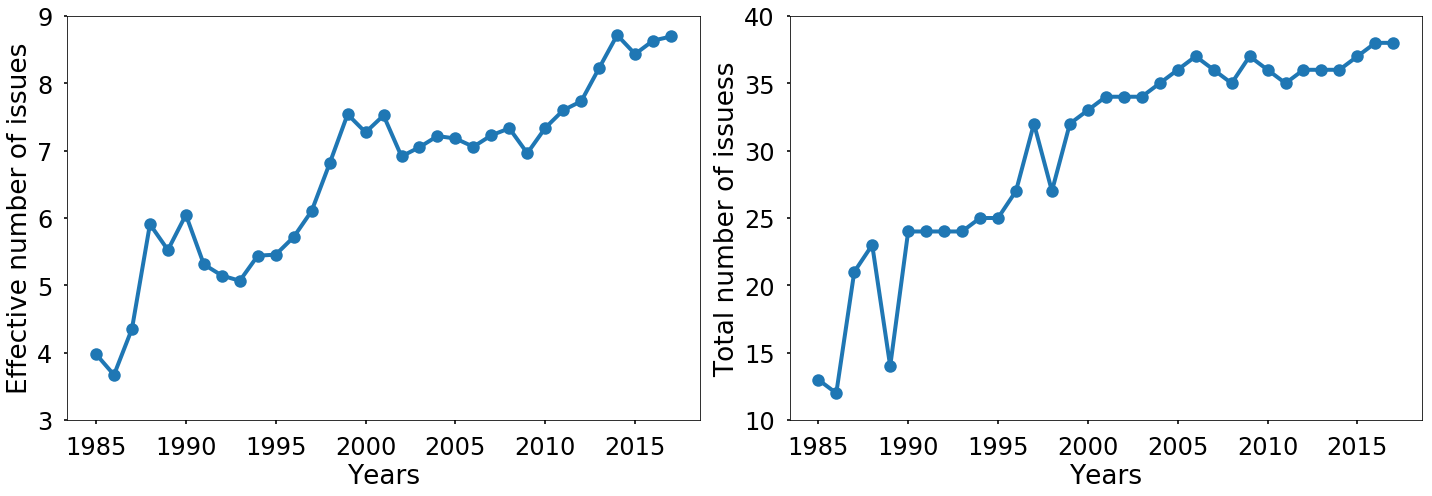

In [24]:
fig, axs = plt.subplots(1,2,figsize=(20,7))

ax = axs[0]
ax.plot(table.year, 2**all_entropies,'.-',lw=4,ms=25)
ax.set_ylabel('Effective number of issues')
ax.set_xlabel('Years')
ax.set_ylim(3,9)

ax = axs[1]
ax.plot(table.year, n_issues,'.-',lw=4,ms=25)
ax.set_ylabel('Total number of issues')
ax.set_xlabel('Years')
ax.set_ylim(10,40)

plt.tight_layout()
plt.savefig('images/Entropy_MII.png',dpi=200)
plt.show()

The yearly data shows the same behaviour as the monthly data: the entropy of the MII distribution rises over time, but so does the number of issues included in the MII. 

In [66]:
table = years_table
tplus1 = table[table.index>table.index[0]]

eps = [0.001, 0.01, 0.1, 0.2]
KLs_faz_True = {}
KLs_faz_False = {}
hammings = {}

for ep in eps:
    relative_entropies_True = []
    relative_entropies_False = []
    relative_entropies_hamm = []
    
    row = table.iloc[0]
    previous_topic_array = np.array(row.values[:-1])
   
    for index, row in tplus1.iterrows():
        topic_array = np.array(row.values[:-1])
        relative_entropies_True  += [ novelty(topic_array, previous_topic_array, metric='KL', ep=ep, faz=True) ]
        relative_entropies_False += [ novelty(topic_array, previous_topic_array, metric='KL', ep=ep, faz=False) ]
        relative_entropies_hamm  += [ novelty(topic_array>0, previous_topic_array>0, metric='hamming') ]
        previous_topic_array = topic_array

    KLs_faz_True[ep]  = relative_entropies_True
    KLs_faz_False[ep] = relative_entropies_False
    hammings[ep]      = relative_entropies_hamm
    
year_table = table

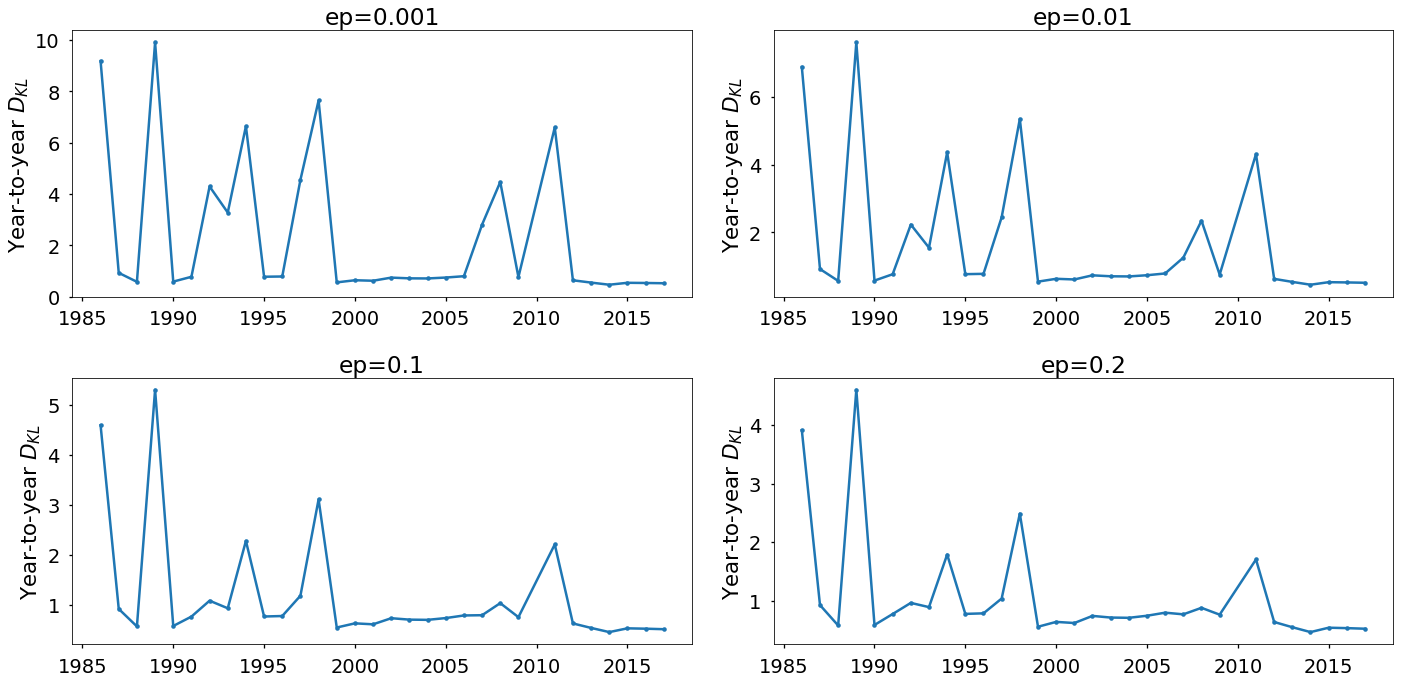

In [777]:
# Fill all zeros = False:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

for ep,ax in zip(eps,axs):
    ax.plot(year_table.year[1:], KLs_faz_False[ep], '.-')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Year-to-year $D_{KL}$')
    
plt.tight_layout()
plt.show()

When aggregating over months, varying the value of ep when filling only the zeros which are being compared to non-zero entries in the other month or year makes no difference. Still, the addition of new MIIs is a great surprise, reflecting in the high peaks in the earlier decades.

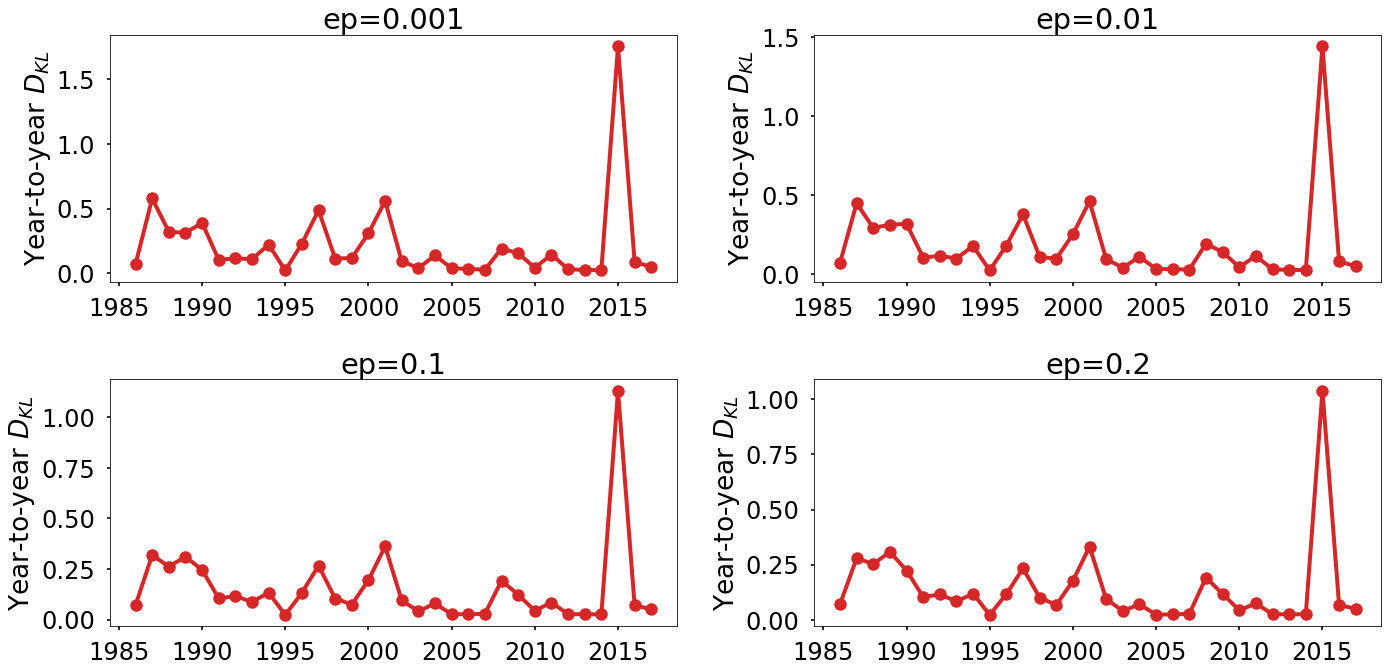

In [67]:
# Fill all zeros = True:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

for ep,ax in zip(eps,axs):
    ax.plot(year_table.year[1:], KLs_faz_True[ep], '.-',lw=4,ms=25, c='#d62728')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Year-to-year $D_{KL}$')
    
plt.tight_layout()
plt.show()

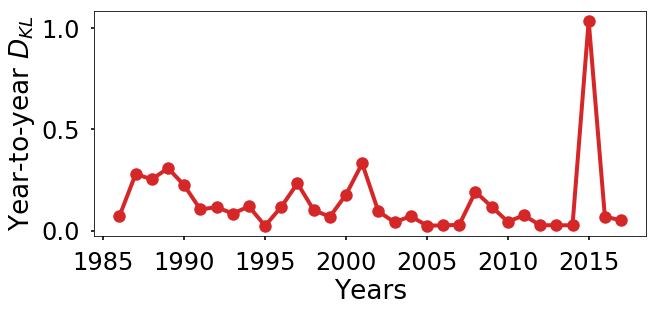

In [77]:
# For IC2S2

fig, ax = plt.subplots(1,figsize=(10,5))

x = year_table.year[1:]
y = KLs_faz_True[ep]

data = [ [i,j] for i,j in zip(x,y)]
np.savetxt('MII.dat',data)

ax.plot(x, y, '.-',lw=4,ms=25, c='#d62728')
ax.set_ylabel(r'Year-to-year $D_{KL}$')
ax.set_xlabel('Years')

#plt.legend(['Public opinion'])
plt.tight_layout()
plt.savefig('mii_divergence.svg',dpi=200)
plt.show()

When replacing all zeros with ep, again, the  artificial parameter ep also does not make much difference, and the addition of new MIIs is not as surprising. The biggest peak comes from 2015, where we already know that new topics such as "Imm" were introduced, without the removal of "Rac".

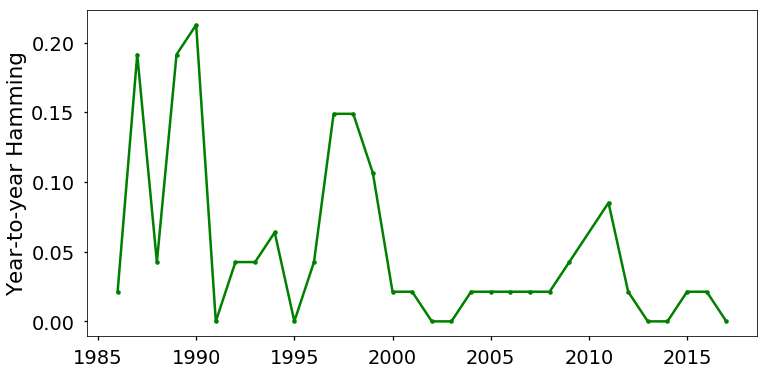

In [779]:
# Hamming distance
plt.figure(figsize=(12,6))

plt.plot(year_table.year[1:], hammings[ep], '.-', c='g')

plt.ylabel(r'Year-to-year Hamming')
plt.show()

When aggregating over months, the year-to-year Hamming distance still shows results similar to relative entropy.

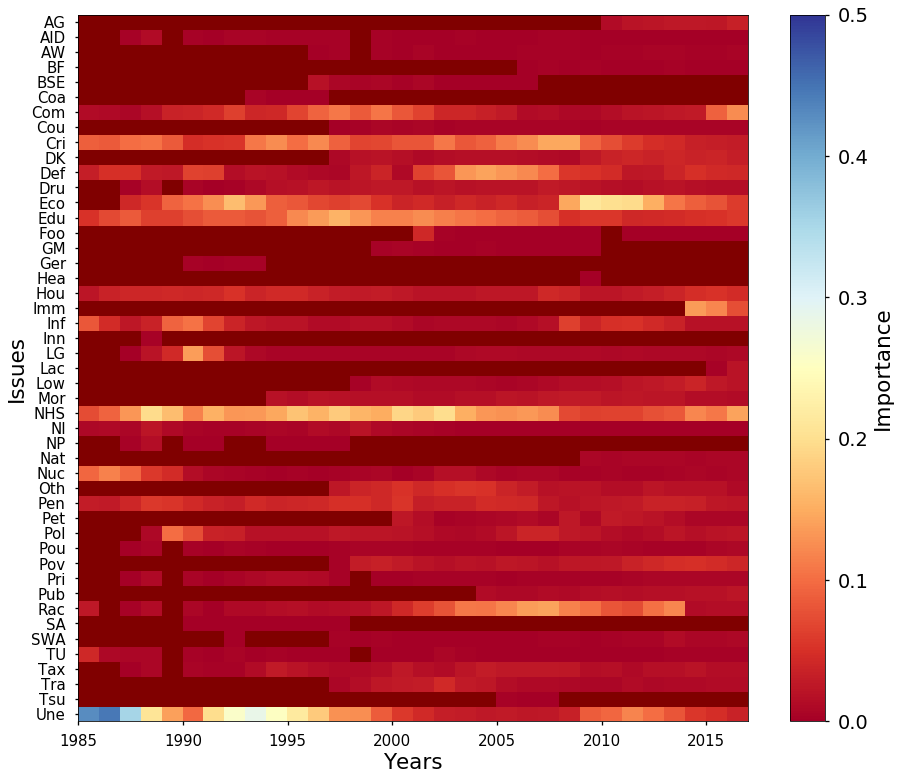

In [672]:
M = years_table.as_matrix()[:,:-1]
normM = np.array([ m/sum(m) for m in M ])

fig, ax = plt.subplots(1, figsize=(15,13))
#plt.figure(figsize=(15,13))

Mshow = np.flipud(normM.T)
Mshow[Mshow==0.0] = -1

pc = plt.pcolor(Mshow, cmap='RdYlBu')

#pc.cmap.set_under('rosybrown')
pc.cmap.set_under('maroon')
pc.set_clim(0,0.5)

c = plt.colorbar()
c.set_label('Importance')

yticks = np.arange(len(keys)-1)+0.5
yticklabels = list(reversed(keys.values[:-1]))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=15)
ax.set_ylabel('Issues')

xticks = np.arange(0,35,5)
xticklabels = np.arange(1985,2020,5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=15)
ax.set_xlabel('Years')

plt.show()

Same heatmap as above, but aggregated over years. Remember rows are normalised.

As a next step, it will be important to merge overlapping topics.

Since the coding of questions into topics has changed over the years,
- Can we get the raw data (poll text)?
- Can we get the codebooks used to produce these topics?
- Is there any official guide to the code changes?
- Do we have any knwoledge of the coding process? did they re-code old issues, for instance? How often do codes change?

Once we have merged the overlapping topics, we can then look again at entropy, relative entropy, and Hamming distance as well. For the relative entropy and Hamming distance, since we are interested in the absolute value of the second derivative of these functions, it might be interesting to do a linear and a quadratic fit to these time series and look at their goodness of fit (possibly applying a f-test).

We should also vary the window we're looking at / comparing with: maybe compare a month to the previous year, or a rolling window of 3 months to the previous 3 months.

This analysis should also be suited to topics coming from topic modelling, or from word frequency vectors, or vectors coming from word2vec or doc2vec.

In [206]:
all_topics = {
 'AG' : 'Ageing Population/Social Care for the Elderly',
 'AID': 'AIDS',
 'AW' : 'Animal Welfare',
 'BF' : 'Bird Flu/Flu Pandemic',
 'BSE': 'BSE/Beef',
 'Coa': 'Coal Review/Pit Closures',
 'Com': 'Common Market/EU/Europe/Single European Currency',
 'Cou': 'Countryside/Rural Life',
 'Cri': 'Crime/Law & Order/Violence/Vandalism',
 'DK' : "Don't know",
 'Def': 'Defence/Foreign Affairs/International Terrorism',
 'Dru': 'Drug Abuse',
 'Eco': 'Economy/Economic Situation',
 'Edu': 'Education/Schools',
 'Foo': 'Foot And Mouth Outbreak/Farming Crisis',
 'GM' : 'GM/GM (Genetically Modified) Foods',
 'Ger': 'German Reunification/Eastern Europe',
 'Hea': 'Heathrow/third runway at Heathrow',
 'Hou': 'Housing',
 'Inf': 'Inflation/Prices',
 'Inn': 'Inner Cities',
 'Imm': 'Immigration',
 'Lac': 'Lack of faith in govt/politics',
 'LG' : 'Local Government/Council Tax/Poll Tax',
 'Low': 'Low Pay/Minimum Wage/Fair Wages',
 'Mor': 'Morality/Individual Behaviour',
 'NHS': 'NHS / Hospitals / Health Care',
 'Nat': 'Nationalisation/Government control of institutions',
 'NI' : 'Northern Ireland',
 'NP' : 'Nuclear Power/Fuels',
 'Nuc': 'Nuclear Weapons/Nuclear War/Disarmament',
 'Oth': 'Other',
 'Pen': 'Pensions/Social Security',
 'Pet': 'Petrol Prices/Fuel',
 'Pol': 'Pollution/Environment',
 'Pou': 'Pound/Exchange Rate/Value Of Pound',
 'Pov': 'Poverty/Inequality',
 'Pri': 'Privatisation',
 'Pub': 'Public Services In General',
 'Rac': 'Race Relations/Immigration/Immigrants',
 'SA' : 'Scottish Assembly',
 'SWA': 'Scottish/Welsh Assembly/Devolution Constitutional Reform',
 'TU' : 'Trade Unions/Strikes',
 'Tax': 'Taxation',
 'Tra': 'Transport/Public Transport',
 'Tsu': 'Tsunami/South East Asia',
 'Une': 'Unemployment/Factory Closure/Lack Of Industry'
}